<a href="https://colab.research.google.com/github/blackgreenc/AI/blob/main/index_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 모듈 불러오기

In [3]:
!pip install yfinance
import numpy as np
import tensorflow as tf
import pandas as pd
import yfinance as yf #야후 파이낸스 데이터

     |████████████████████████████████| 6.3 MB 4.2 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=a73171eff9f7e115c5507e2b86b63b4a1849528021373fbcaead93b9c30b3221
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
#아마존
#AMZN = yf.download('AMZN',
#                     start = '2000-01-01',
#                     end = '2021-1-05',
#                     progress = False)
#
#AMZN_data = AMZN[['Adj Close', 'Open', 'High', 'Low', "Close","Volume"]].round(2)
#AMZN_data.head(15)
#
#print("There are" + str(AMZN_data[:"2000"].shape[0]) + "observations in the training data")
#print("There are" + str(AMZN_data[:"2021"].shape[0]) + "observations in the training data")
#AMZN_data['Adj Close'].plot()

There are0observations in the training data
There are2959observations in the training data


,NDX_Adj Close,NDX_Open,NDX_High,NDX_Low,NDX_Close,NDX_Volume
Date,,,,,,
2021-10-04,14472.12,14713.60,14727.60,14384.93,14472.12,4539650000
2021-10-01,14791.87,14731.38,14830.84,14555.12,14791.87,4688550000
2021-09-30,14689.62,14830.30,14888.22,14684.55,14689.62,5910550000
2021-09-29,14752.89,14835.51,14914.92,14727.41,14752.89,5246170000
2021-09-28,14770.30,15001.98,15040.57,14758.98,14770.30,4954270000
2021-09-27,15204.82,15205.23,15240.58,15106.45,15204.82,4619450000
2021-09-24,15329.68,15222.97,15345.54,15209.16,15329.68,3972140000
2021-09-23,15316.58,15231.20,15356.92,15199.43,15316.58,4176520000
2021-09-22,15176.51,15073.96,15230.34,15029.90,15176.51,4229870000


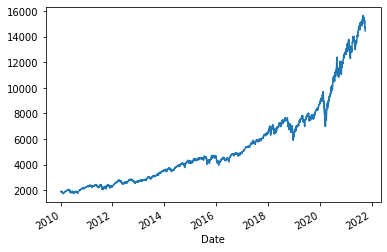

In [5]:
# 나스닥 100
NDX  = yf.download('NDX',
                     start = '2010-01-01',
                     end = '2021-10-05',
                     progress = False)

NDX_data = NDX[['Adj Close', 'Open', 'High', 'Low', "Close","Volume"]].round(2)
NDX_data.rename(columns={'Adj Close':'NDX_Adj Close', 'Open':'NDX_Open', 'High':'NDX_High', 'Low':'NDX_Low', 'Close':'NDX_Close', 'Volume':'NDX_Volume' }, inplace=True)


print("There are" + str(NDX_data[:"2006"].shape[0]) + "observations in the training data")
print("There are" + str(NDX_data[:"2021"].shape[0]) + "observations in the training data")

NDX_data['NDX_Adj Close'].plot()
NDX_data.shape
NDX_data.loc[::-1].head(10)

There are0observations in the training data
There are2959observations in the test data


,GOLD_Adj Close,GOLD_Open,GOLD_High,GOLD_Low,GOLD_Close,GOLD_Volume
Date,,,,,,
2021-10-04,18.23,17.99,18.42,17.96,18.23,17838500
2021-10-01,17.99,18.08,18.08,17.73,17.99,20640200
2021-09-30,18.05,17.69,18.22,17.65,18.05,22313600
2021-09-29,17.58,18.04,18.15,17.56,17.58,23570900
2021-09-28,18.10,17.81,18.12,17.57,18.10,26643200
2021-09-27,17.95,18.06,18.26,17.87,17.95,20717300
2021-09-24,18.03,18.09,18.27,18.03,18.03,13371200
2021-09-23,18.23,18.30,18.38,18.09,18.23,19733600
2021-09-22,18.45,18.55,18.81,18.41,18.45,17054600


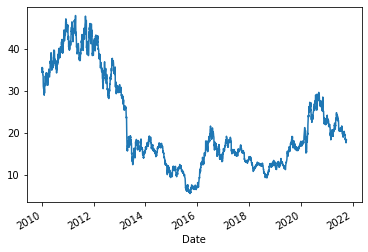

In [37]:
# 금값
GOLD  = yf.download('GOLD',
                     start = '2010-01-01',
                     end = '2021-10-05',
                     progress = False)

GOLD_data = GOLD[['Adj Close', 'Open', 'High', 'Low', "Close","Volume"]].round(2)
GOLD_data.rename(columns={'Adj Close':'GOLD_Adj Close', 'Open':'GOLD_Open', 'High':'GOLD_High', 'Low':'GOLD_Low', 'Close':'GOLD_Close', 'Volume':'GOLD_Volume' }, inplace=True)


print("There are" + str(GOLD_data[:"2006"].shape[0]) + "observations in the training data")
print("There are" + str(GOLD_data[:"2021"].shape[0]) + "observations in the test data")

GOLD_data['GOLD_Adj Close'].plot()
GOLD_data.loc[::-1].head(10)

There are0observations in the training data
There are2959observations in the training data


,WTI_Adj Close,WTI_Open,WTI_High,WTI_Low,WTI_Close,WTI_Volume
Date,,,,,,
2021-10-04,4.11,4.00,4.17,3.98,4.11,5325700
2021-10-01,3.89,3.72,3.89,3.72,3.89,2589700
2021-09-30,3.72,3.68,3.73,3.57,3.72,2491800
2021-09-29,3.70,3.69,3.74,3.56,3.70,2234700
2021-09-28,3.67,3.78,3.86,3.61,3.67,3534600
2021-09-27,3.67,3.50,3.72,3.50,3.67,4236000
2021-09-24,3.38,3.27,3.44,3.24,3.38,2290100
2021-09-23,3.36,3.25,3.39,3.21,3.36,2409400
2021-09-22,3.21,3.18,3.31,3.18,3.21,2466200


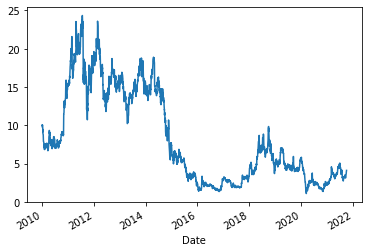

In [38]:
# 기름 
WTI  = yf.download('WTI',
                     start = '2010-01-01',
                     end = '2021-10-05',
                     progress = False)

WTI_data = WTI[['Adj Close', 'Open', 'High', 'Low', "Close","Volume"]].round(2)
WTI_data.rename(columns={'Adj Close':'WTI_Adj Close', 'Open':'WTI_Open', 'High':'WTI_High', 'Low':'WTI_Low', 'Close':'WTI_Close', 'Volume':'WTI_Volume' }, inplace=True)


print("There are" + str(WTI_data[:"2006"].shape[0]) + "observations in the training data")
print("There are" + str(WTI_data[:"2021"].shape[0]) + "observations in the training data")

WTI_data['WTI_Adj Close'].plot()
WTI_data.loc[::-1].head(10)

In [39]:
all_data = pd.concat([ NDX_data, WTI_data, GOLD_data], axis=1)
all_data.head(12)

,NDX_Adj Close,NDX_Open,NDX_High,NDX_Low,NDX_Close,NDX_Volume,WTI_Adj Close,WTI_Open,WTI_High,WTI_Low,WTI_Close,WTI_Volume,GOLD_Adj Close,GOLD_Open,GOLD_High,GOLD_Low,GOLD_Close,GOLD_Volume
Date,,,,,,,,,,,,,,,,,,
2010-01-04,1886.70,1882.69,1890.02,1881.63,1886.70,1931380000,9.82,11.90,12.46,11.86,12.26,838800,34.34,40.70,41.18,40.25,40.39,14212200
2010-01-05,1888.43,1887.28,1891.33,1877.52,1888.43,2367860000,9.89,12.30,12.63,12.17,12.34,625400,34.77,40.66,41.10,40.04,40.89,13018600
2010-01-06,1878.42,1887.91,1893.21,1873.90,1878.42,2253340000,10.08,12.41,12.65,12.39,12.58,604700,35.51,41.32,42.34,41.14,41.76,12329200
2010-01-07,1876.72,1878.16,1881.33,1867.62,1876.72,2270050000,9.98,12.60,12.70,12.24,12.45,565300,35.00,41.67,41.67,40.89,41.17,9291000
2010-01-08,1892.59,1870.90,1893.25,1868.55,1892.59,2145390000,10.02,12.37,12.54,12.12,12.50,521100,35.22,41.60,41.67,40.70,41.43,9198600
2010-01-11,1886.24,1896.05,1897.49,1876.25,1886.24,2077890000,9.94,12.65,13.27,12.14,12.40,1177400,35.40,42.57,42.64,41.32,41.64,13778000
2010-01-12,1861.79,1874.75,1876.37,1852.31,1861.79,2368320000,9.54,12.33,12.43,11.80,11.90,921200,34.26,41.16,41.52,39.95,40.30,12126500
2010-01-13,1886.13,1868.20,1890.81,1855.27,1886.13,2318350000,9.15,11.97,12.00,11.36,11.42,1778300,34.60,40.53,40.80,39.43,40.70,9581100
2010-01-14,1886.52,1880.46,1891.73,1880.35,1886.52,2254170000,9.46,11.42,11.90,11.42,11.80,890300,34.41,40.65,40.85,39.95,40.47,8470600


In [40]:
#all_Adj_data = pd.concat([NDX_data['NDX_Adj Close'], GOLD_data['GOLD_Adj Close'],WTI_data['WTI_Adj Close']], axis = 1)
#all_Adj_data.head()
#
#all_Adj_data.shape

입력값과 출력값 데이터를 위한 코드

In [10]:
def ts_train_test_normalize(all_data, time_steps, for_periods):
    """
    input: 
        data: dataframe with dates and price data
    output: 
        X_train, y_train: data from 2013/1/1-2018/12/31 
        X_test : data from 2019- 
        sc :     insantiated MinMaxScaler object fit to the training data 
    """
    # create training and test set 
    ts_train = all_data[:'2019'].iloc[:,0:1].values
    ts_test = all_data['2020':].iloc[:,0:1].values 
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    
    # scale the data 
    from sklearn.preprocessing import MinMaxScaler 
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)
    
    # create training data of s samples and t time steps 
    X_train = [] 
    y_train = [] 
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Reshaping X_train for efficient modelling 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 ))
    
    inputs = pd.concat((all_data["NDX_Adj Close"][:'2019'], all_data["NDX_Adj Close"]['2020':]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    
    # Preparing X_test 
    X_test = [] 
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train , X_test, sc

In [41]:
#X_train, y_train, X_test, sc = ts_train_test_normalize(NDX_data, 5, 2)
X_train, y_train, X_test, sc = ts_train_test_normalize(all_data, 5, 2)

X_train.shape[0], X_train.shape[1]

(2510, 5)

In [42]:
# 3차원의 X_train을 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see, y_train_see], axis = 1)

# 3차원의 X_test를 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
# There are ? samples in the training data

print("There are " + str(X_test.shape[0]) + " samples in the test data")
# There are ? samples in the test data

There are 2510 samples in the training data
There are 441 samples in the test data


In [43]:
def LSTM_model(X_train, y_train, X_test, sc):
    # import neccesary modul
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD

    # LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50,
                           return_sequences = True,
                           input_shape = (X_train.shape[1],1),
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units = 2))

    # compiling
    my_LSTM_model.compile(optimizer =SGD(lr = 0.02, decay = 1e-7, momentum = 0.9, nesterov = False),
                          loss = 'mean_squared_error') # momentum은 관성을 나타냄
    
    # training data 세트에 피팅하기 (조기 중단은 추가함)
    my_LSTM_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)

    # X_test를 LSTM model에 넣어서 예측하기
    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

In [44]:
def actual_pred_plot(preds):
    # Plot the actual vs prediction

    actual_pred = pd.DataFrame(columns = ['NDX_Adj Close', 'prediction'])
    actual_pred['NDX_Adj Close'] = NDX_data.loc['2020':, 'NDX_Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:, 0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['NDX_Adj Close']), np.array(actual_pred['prediction']))

    return (m.result().numpy(), actual_pred.plot())

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(2997434.2, <matplotlib.axes._subplots.AxesSubplot at 0x7f90a4bb98d0>)

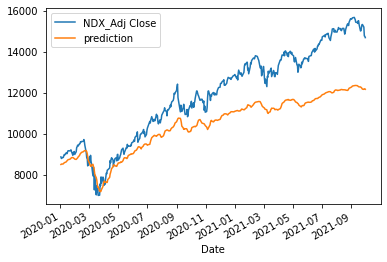

In [45]:
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)

In [47]:
y_pred = pd.DataFrame(LSTM_prediction[:, 0])
y_test = NDX_data.loc['2020':, 'NDX_Adj Close'][0:len(LSTM_prediction)]
#y_test = all_data.loc['2020':, 'NDX_Adj Close'][0:len(LSTM_prediction)]
y_test.reset_index(drop = True, inplace = True)

In [48]:
# 예측성능 출력
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)

    Result = pd.DataFrame(data = [MAE, RMSE, RMSLE, R2],
                          index = ['MAE', 'RMSE', 'RMSLE', 'R2'],
                          columns = ['Results'])
    
    return Result

In [49]:
# result check
confirm_result(y_test, y_pred)

,Results
MAE,1470.693073
RMSE,1731.310042
RMSLE,0.137924
R2,0.408871


In [50]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mean_squared_error')
    
    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(795621.9, <matplotlib.axes._subplots.AxesSubplot at 0x7f90ab1f0ed0>)

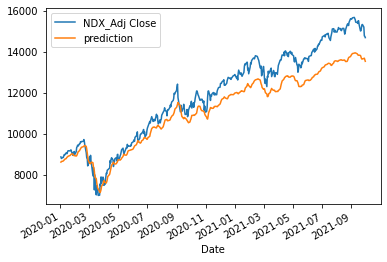

In [51]:
my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

In [52]:
y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
y_test_gru=NDX_data.loc['2020':,'NDX_Adj Close'][0:len(GRU_prediction)]
y_test_gru.reset_index(drop=True, inplace=True)

In [53]:
confirm_result(y_test_gru, y_pred_gru)

,Results
MAE,758.280227
RMSE,891.976401
RMSLE,0.068852
R2,0.843094
